# Baseline trials
Generates single-agents interactions with unmodified wikipedia model to find optimal threshold for both individual and pair-wise games

In [1]:
import glob
from diversity_abm.interaction import Interaction
from diversity_abm.utils import compute_thresholds, load_matrix
from multiprocessing import Pool
import pandas as pd
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime

In [2]:
models = ['diversity_abm/models/wiki_euclidean_distance.tsv']
animals = pd.read_csv('diversity_abm/models/animal_list.csv')['Animals'].values.tolist()

In [3]:
thresholds = compute_thresholds(models, 
                                q=[round(n,2) for n in np.arange(0.05, 1.0, 0.05)], 
                                round_at=5)

In [4]:
print(f'thresholds: {thresholds}')

thresholds: {0.05: 0.01105, 0.1: 0.01151, 0.15: 0.01179, 0.2: 0.01199, 0.25: 0.01216, 0.3: 0.01231, 0.35: 0.01245, 0.4: 0.01258, 0.45: 0.0127, 0.5: 0.01281, 0.55: 0.01293, 0.6: 0.01304, 0.65: 0.01314, 0.7: 0.01326, 0.75: 0.01337, 0.8: 0.0135, 0.85: 0.01364, 0.9: 0.01381, 0.95: 0.01407}


In [5]:
nr_sim = len(animals)
date = datetime.now().strftime('%y_%m_%d')

In [6]:
def run_baseline(m, t, outpath):
    print(f'threshold: {t}')
    m_id = m.split('.')[0].split('/')[2].split('_')[0]
    log_id = f'{m_id}'
    i = Interaction(nr_agents=1,
                    matrix_filenames=m, 
                    threshold=t,
                    save_folder=outpath,
                    log_id=log_id,
                    nr_sim=nr_sim)
    i.run_interaction(seeds=animals)

In [11]:
for v in thresholds.values():
   run_baseline(models[0], v, f'diversity_abm/logs/{date}/baseline')

threshold: 0.01105


TypeError: 'NoneType' object is not subscriptable

## Plot baseline performance

In [14]:
fs = glob.glob(f'animal_game/logs/{date}/baseline/*')
for idx, f in enumerate(fs):
    df = pd.read_csv(f, index_col=0)
    print(f, df.iter.max())
    base = df.groupby('iter').agg({'turn':'max', 
                                   'threshold':'first'}).reset_index()
    base.columns = ['iter', 'performance', 'threshold']
    base['threshold_q'] = base['threshold'].apply(lambda x: [k for k,v in thresholds.items() 
                                                             if x==v])
    if idx == 0:
        base_agg = base.copy()
    else:
        base_agg = pd.concat([base_agg, 
                              base], ignore_index=True)

animal_game/logs/23_01_05/baseline/wiki_1_0.05059.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.05425.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.0376.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.02814.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.03134.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.0722.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.04071.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.06224.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.08792.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.04376.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.02468.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.04714.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.0345.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.0787.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.01096.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.0669.txt 239
animal_game/logs/23_01_05/baseline/wiki_1_0.02083.txt 239
animal_game/logs/23

Plot performance of reference agent per threshold

In [15]:
base_agg['threshold_q'] = base_agg['threshold_q'].apply(lambda x: x[0])

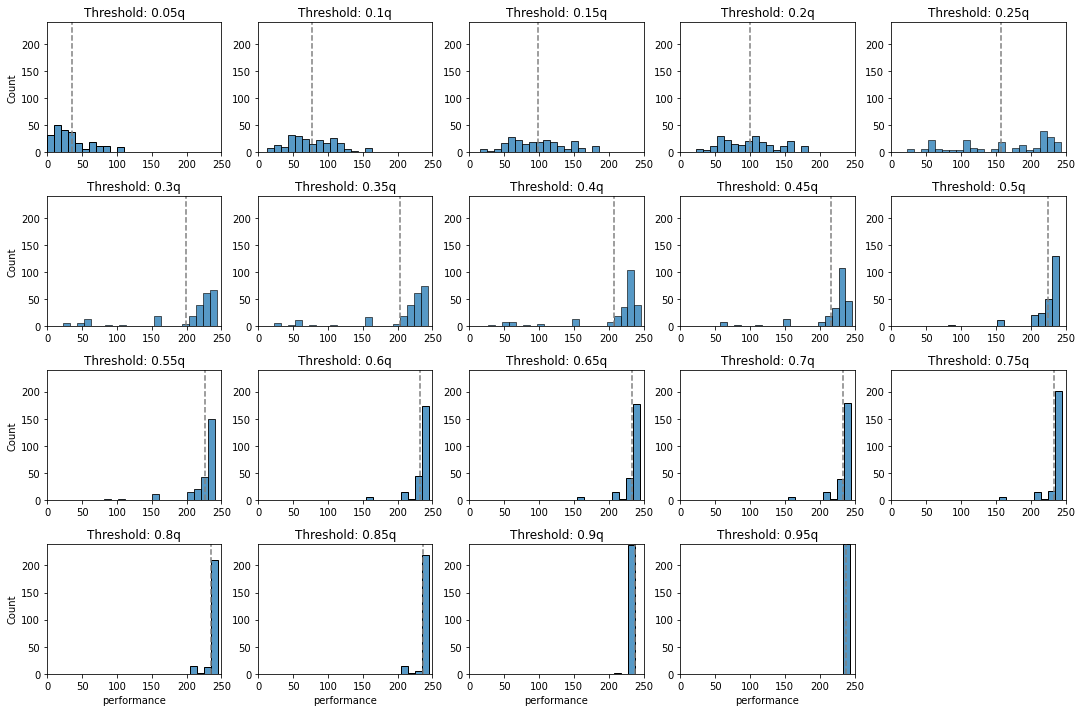

In [18]:
f, ax = plt.subplots(nrows=4, ncols=5, figsize=(15,10))
coords = list(itertools.product(range(4), range(5)))
thresholds = sorted(base_agg.threshold.unique().tolist())
thresholds_q = sorted(base_agg.threshold_q.unique().tolist())
for idx, c in enumerate(coords[:-1]):
    sns.histplot(data=base_agg[base_agg['threshold_q']==thresholds_q[idx]], 
                 x='performance', 
                 binwidth=10, 
                 ax=ax[c])
    ax[c].vlines(base_agg[base_agg['threshold_q']==thresholds_q[idx]].performance.mean(),
                          0, 240,
                          linestyle='--', color='grey')
    ax[c].set_xlim(0,250)
    if c[1] != 0:
        ax[c].set_ylabel('')
    if c[0] != 3:
        ax[c].set_xlabel('')
    ax[c].set_ylim(0,240)
    ax[c].set_title(f'Threshold: {thresholds_q[idx]}q')
f.delaxes(ax[-1,-1])
plt.tight_layout()
plt.show()

Picking .15 for now as a threshold for future interactions, but would be nice to also try a couple more.

In [ ]:
target = np.tril()

In [ ]:
f, ax = plt.subplots(figsize=(13,4))
sns.histplot(load_matrix(models[0]).values.ravel())
for idx, t in enumerate(thresholds):
    plt.axvline(t, linestyle='--', color='grey')
    plt.ylim(0,2050)
    plt.annotate(thresholds_q[idx], xy=(t-0.0001,1800), 
                 xycoords='data', rotation=90, fontsize=7.5)
plt.show()

### Visualize through UMAP
[ Still targeted to large spaces ]

In [19]:
import umap
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text
reducer = umap.UMAP(n_neighbors=5, min_dist=0.1)

In [22]:
vecs = pd.read_csv('diversity_abm/models/wiki_vectors_small.tsv', sep='\t', 
                   header=None, index_col=0)
vecs.index = animals
scaled_vecs = StandardScaler().fit_transform(vecs)
embedding = reducer.fit_transform(scaled_vecs)

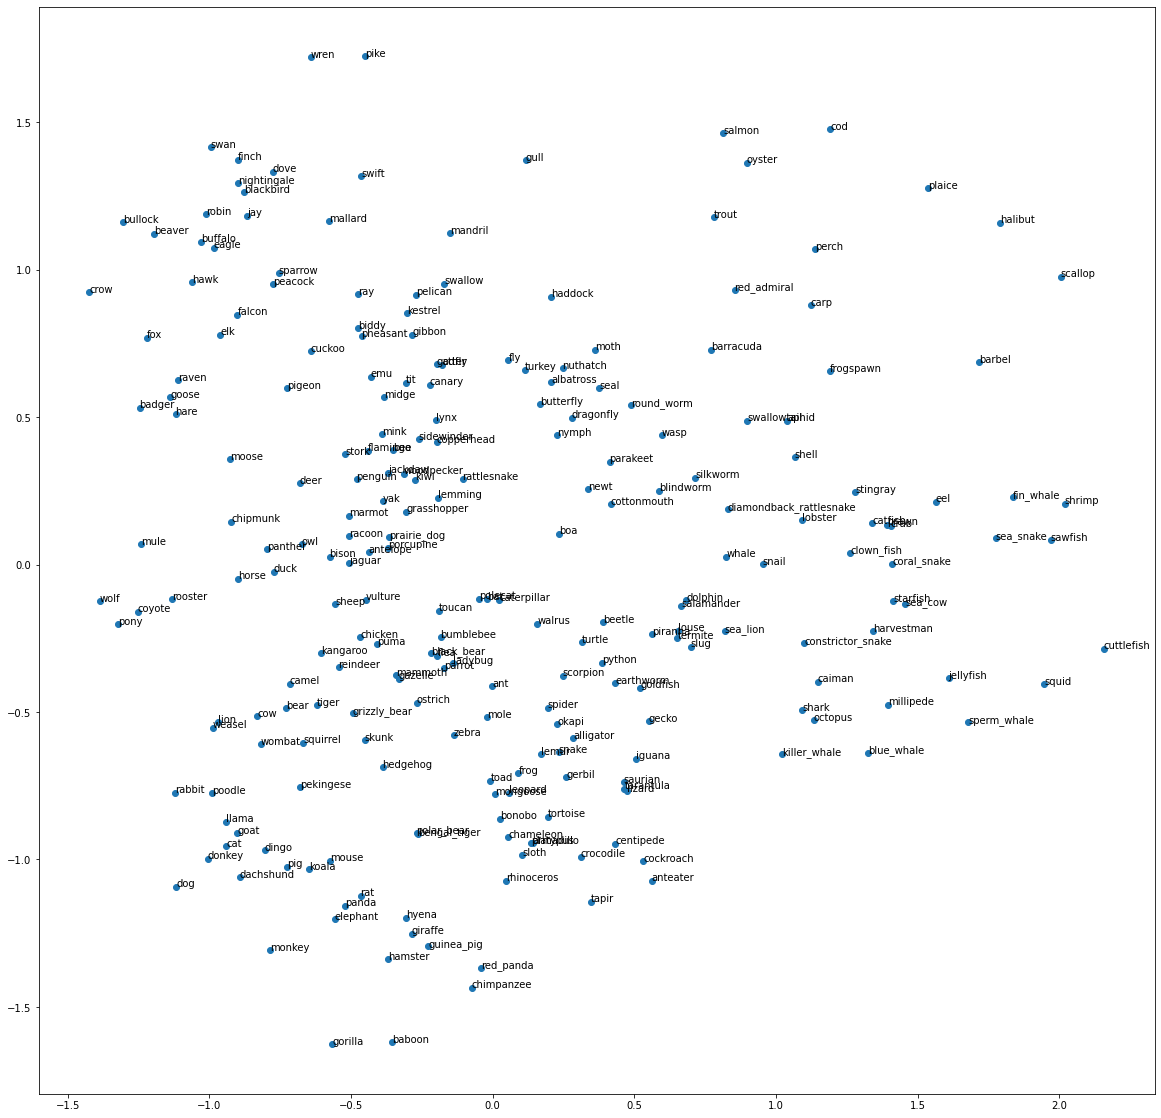

In [40]:
f, ax = plt.subplots(figsize=(20,20))
plt.scatter(vecs.iloc[:,0], vecs.iloc[:, 1]) # embeddings
for idx in range(vecs.shape[0]):
    plt.annotate(animals[idx], (vecs.iloc[idx,0], vecs.iloc[idx,1])) # also embeddings
plt.show()